# EEG analysis of the Relax Protocol with Deep Learning
In this notebook, I am going to analyze EEG signals collected during evening reading sessions for days where I perfomed the Relax Protocol right before the session (Post_Relax_Protocol_Reading_X_xyz.csv) and on days where no protocol was performed (Post_No_Protocol_Reading_X_xyz.csv.csv)

My hypothesis is that we will see differences between these two types of sessions, specifically on the alpha band, since this is the frequency band most robust to noise in the EEG. 

I collected my own EEG signals using the MW75 Neuro and its Research Kit.

In this notebook I will cover:
- Loading raw EEG data
- Apliying filters
- Removing outliers

In 2 separate notebooks I will cover:

- Extracting features (in particual alpha power)
- Use a convolutional neural network to identify if there are differences between the EEG datasets

In [1]:
# Re-loading functions
%load_ext autoreload
%autoreload 2

In [2]:
# Loading libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal, fft
from glob import glob
from collections import defaultdict
import os


In [3]:
# Retrieving relevant filenames
filenames = glob("data/relax_protocol/*.csv")
relax_protocol = "Relax-Protocol"
no_protocol = "No-Protocol"
relax_protocol_filenames = []
no_protocol_filenames = []
for filename in filenames:
    if relax_protocol in filename:
        relax_protocol_filenames.append(filename)
    elif no_protocol in filename:
        no_protocol_filenames.append(filename)


In [4]:
filenames

['data/relax_protocol\\Post-No-Protocol-Reading_2_a59d54dbeb0561f6.csv',
 'data/relax_protocol\\Post-No-Protocol-Reading_3_6ec4773de7bdd332.csv',
 'data/relax_protocol\\Post-No-Protocol-Reading_4_5e3f45ddcf9f24fb.csv',
 'data/relax_protocol\\Post-No-Protocol-Reading_5_8f35d37b247631df.csv',
 'data/relax_protocol\\Post-No-Protocol-Watching_Lecture_1_84cba488007bbde6.csv',
 'data/relax_protocol\\Post-Relax-Protocol-Reading_1-2_fe965c878635715b.csv',
 'data/relax_protocol\\Post-Relax-Protocol-Reading_1_e64ef2cf3314a11d.csv',
 'data/relax_protocol\\Post-Relax-Protocol-Reading_2_08edc179d3350ea7.csv',
 'data/relax_protocol\\Post-Relax-Protocol-Reading_3_2332e9873e86357c.csv',
 'data/relax_protocol\\Post-Relax-Protocol-Working_4_8f0fac001e382227.csv',
 'data/relax_protocol\\Post-Relax-Protocol-Working_5_9c117b95ab00f86c.csv']

In [5]:
# Loading sample datasets
sample_file_id = 0
sample_data_after_protocol = pd.read_csv(relax_protocol_filenames[sample_file_id])
sample_data_no_protocol = pd.read_csv(no_protocol_filenames[sample_file_id])
sample_data_after_protocol

,Timestamp,EventId,Counter,Ref,DRL,Ch1RawEEG,Ch2RawEEG,Ch3RawEEG,Ch4RawEEG,Ch5RawEEG,Ch6RawEEG,Ch7RawEEG,Ch8RawEEG,Ch9RawEEG,Ch10RawEEG,Ch11RawEEG,Ch12RawEEG,FeatureStatus,Checksum
0,2025-10-20T23:11:32.493Z,239,17,1791,1787,-7290.14,-1940.86,-21601.8,-664.691,-10477.2,-5870.33,-429.251,-541.356,-30222.5,-17250.6,6724.25,-7574.22,16,8027
1,2025-10-20T23:11:32.494Z,239,30,1791,1795,-7534.98,-2024.35,-22500.0,-651.387,-10475.7,-5943.07,-474.170,-519.374,-30498.7,-17304.1,6710.07,-7650.28,16,7660
2,2025-10-20T23:11:32.494Z,239,43,1791,1779,-7329.44,-1951.68,-21805.9,-670.723,-10483.9,-5877.36,-431.850,-531.128,-30314.1,-17280.8,6728.59,-7577.01,16,7774
3,2025-10-20T23:11:32.503Z,239,56,1786,1803,-7461.62,-1997.74,-22211.7,-657.229,-10480.0,-5921.09,-452.974,-517.371,-30280.5,-17268.3,6719.32,-7626.01,16,7754
4,2025-10-20T23:11:32.503Z,239,70,1795,1777,-7477.71,-2004.42,-22348.2,-663.761,-10493.1,-5924.59,-463.322,-526.121,-30432.7,-17313.0,6718.58,-7632.52,16,8074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284772,2025-10-20T23:23:21.026Z,239,231,1783,1793,-7730.67,-2933.78,-23609.8,1477.800,-11530.9,-5988.37,-438.597,-5316.980,-29560.9,-16050.2,7021.09,-6346.00,16,8153
284773,2025-10-20T23:23:21.026Z,239,232,1791,1795,-7690.98,-2921.79,-23463.5,1475.250,-11528.8,-5977.48,-429.323,-5317.120,-29681.1,-16048.0,7024.64,-6337.20,16,8348
284774,2025-10-20T23:23:21.026Z,239,233,1789,1797,-7642.82,-2901.24,-23279.8,1475.990,-11526.2,-5961.12,-417.855,-5317.720,-29837.9,-16040.5,7027.26,-6329.03,16,8342
284775,2025-10-20T23:23:21.026Z,239,234,1795,1791,-7617.33,-2891.22,-23196.8,1474.630,-11528.6,-5953.80,-406.101,-5313.210,-29907.9,-16034.8,7032.22,-6315.08,16,7821


In [9]:
# Loading all datasets
# dataset_after_protocol = pd.concat((pd.read_csv(f) for f in focus_protocol_filenames), ignore_index=True)
# dataset_no_protocol = pd.concat((pd.read_csv(f) for f in no_protocol_filenames), ignore_index=True)
# dataset_after_protocol
# Data can easily get too big to do this. Currently it takes over 2 minutes


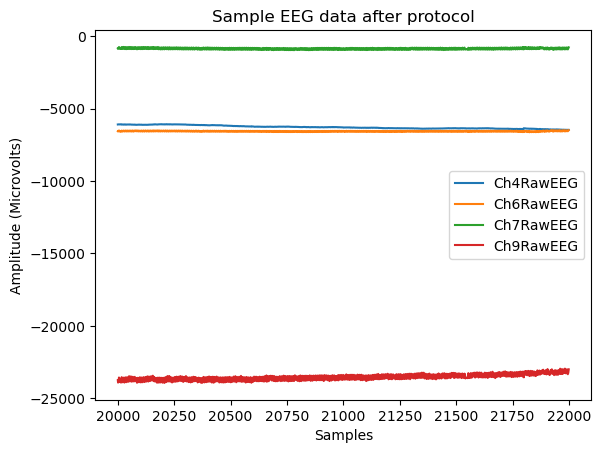

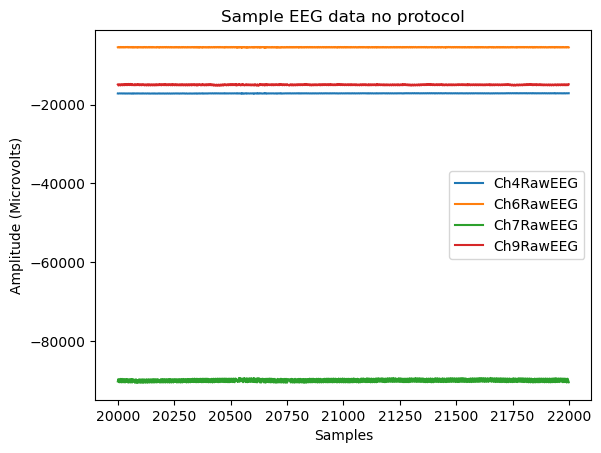

In [6]:
# Plotting sample EEG data
df_dict = {'Sample EEG data after protocol' : sample_data_after_protocol, 
           'Sample EEG data no protocol': sample_data_no_protocol}
channels_of_interest = ['Ch4RawEEG', 'Ch6RawEEG', 'Ch7RawEEG', 'Ch9RawEEG']
samples_of_interest = range(20000,22000)

for title in df_dict:
    df_dict[title][channels_of_interest].iloc[samples_of_interest].plot()
    plt.xlabel('Samples')
    plt.ylabel('Amplitude (Microvolts)')
    plt.title(title)

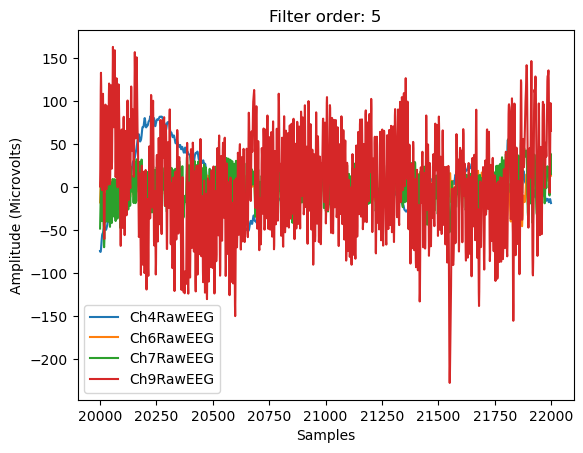

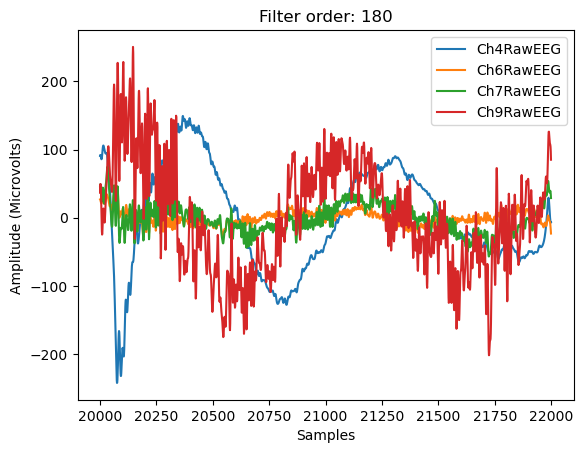

In [7]:
# Comparing filters of different orders

filter_order = 5
strong_filter_order = 8
sampling_rate = 500
lowcut = 50
highcut = 0.5
axis_for_df = 0 
# Scipy uses by default axis -1, which in our dfs, correspond to the number of channels
# Instead we would like to filter along axis 0, which corresponds to the samples

def butter_lowpass(cutoff, fs, order=filter_order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    sos = signal.butter(order, normal_cutoff, btype='low', analog=False, output='sos')
    return sos
def butter_lowpass_filter(data, cutoff, fs, order=filter_order):
    sos = butter_lowpass(cutoff, fs, order=order)
    y = signal.sosfilt(sos, data, axis=axis_for_df)
    return y
def butter_highpass(cutoff, fs, order=filter_order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    sos = signal.butter(order, normal_cutoff, btype='high', analog=False, output='sos')
    return sos
def butter_highpass_filter(data, cutoff, fs, order=filter_order):
    sos = butter_highpass(cutoff, fs, order=order)
    y = signal.sosfiltfilt(sos, data, axis=axis_for_df)
    return y

# Let's check multiple filter orders for one condition
condition = list(df_dict.keys())[0]
filtered_df_dict = dict()
orders_to_try = [5, 180]
for current_filter_order in orders_to_try:
    high_pass_filtered_array = butter_highpass_filter(df_dict[condition][channels_of_interest].values, highcut, sampling_rate, order=current_filter_order)
    band_pass_filtered_array = butter_lowpass_filter(high_pass_filtered_array, lowcut, sampling_rate, order=current_filter_order)

    filtered_df_dict[current_filter_order] = pd.DataFrame(band_pass_filtered_array, columns=channels_of_interest)

    filtered_df_dict[current_filter_order][channels_of_interest].iloc[samples_of_interest].plot()
    plt.xlabel('Samples')
    plt.ylabel('Amplitude (Microvolts)')
    plt.title(f'Filter order: {current_filter_order}')


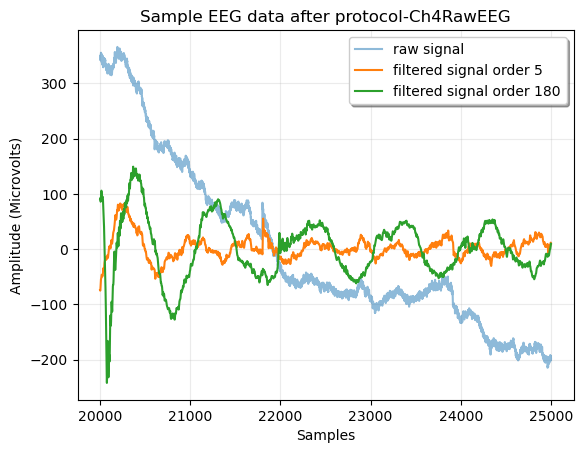

In [8]:
# Let's check for lag and distortions
x = df_dict[condition][channels_of_interest[0]].iloc[20000:25000]
baseline_correction = np.mean(x)
x_bc = x - baseline_correction
y = filtered_df_dict[orders_to_try[0]][channels_of_interest[0]].iloc[20000:25000]
y2 = filtered_df_dict[orders_to_try[1]][channels_of_interest[0]].iloc[20000:25000]
plt.plot(x_bc, alpha=0.5, label='raw signal')
plt.plot(y, label=f'filtered signal order {orders_to_try[0]}')
plt.plot(y2, label=f'filtered signal order {orders_to_try[1]}')
plt.legend(framealpha=1, shadow=True)
plt.grid(alpha=0.25)
plt.xlabel('Samples')
plt.ylabel('Amplitude (Microvolts)')
plt.title(f'{condition}-{channels_of_interest[0]}')
plt.show()

A very high filter order of 180 is significantly delayed and it starts introducing distortions to the data

Getting EEG channel names

In [9]:
eeg_columns = df_dict[condition].columns[df_dict[condition].columns.str.contains('EEG')]

Applying filter of order 5

In [10]:
filtered_df_dict = dict()
for condition in df_dict:
    high_pass_filtered_array = butter_highpass_filter(df_dict[condition][eeg_columns].values, highcut, sampling_rate, order=filter_order)
    band_pass_filtered_array = butter_lowpass_filter(high_pass_filtered_array, lowcut, sampling_rate, order=filter_order)
    filtered_df_dict[condition] = pd.DataFrame(band_pass_filtered_array, columns=eeg_columns)


In [11]:
filtered_df_dict['Sample EEG data after protocol']

,Ch1RawEEG,Ch2RawEEG,Ch3RawEEG,Ch4RawEEG,Ch5RawEEG,Ch6RawEEG,Ch7RawEEG,Ch8RawEEG,Ch9RawEEG,Ch10RawEEG,Ch11RawEEG,Ch12RawEEG
0,0.065704,0.018532,0.240861,0.014221,-0.007710,0.019058,0.006773,0.008676,0.110265,0.027337,0.001020,0.027143
1,0.275985,0.059306,1.010986,0.144836,-0.067267,0.077862,0.003149,0.106132,0.635956,0.176317,-0.009099,0.146182
2,0.003871,-0.146468,-0.068506,0.682878,-0.293085,-0.010719,-0.199647,0.576137,1.351806,0.473143,-0.100469,0.275395
3,-2.768851,-1.344432,-10.760634,2.031144,-0.863258,-0.825034,-1.036594,1.937806,0.557218,0.604654,-0.397078,-0.019357
4,-10.542083,-4.386894,-40.878256,4.390313,-1.961175,-3.055130,-2.919210,4.694215,-3.880141,-0.017703,-0.959869,-1.328748
...,...,...,...,...,...,...,...,...,...,...,...,...
284772,149.924564,40.835875,588.046666,-7.153690,5.621448,37.193263,5.850032,-20.912165,-115.699335,1.977755,-0.802023,3.126497
284773,161.361036,45.980379,629.457242,-7.421373,5.315943,39.901072,8.032520,-20.907007,-154.354204,1.457693,-0.605313,6.762807
284774,159.538506,46.902683,620.549255,-7.203112,5.092356,39.058216,8.809266,-19.804729,-165.653404,1.062832,-0.464461,8.758833
284775,147.226817,43.941673,574.323756,-6.825528,5.405700,35.378162,7.892213,-18.150916,-144.406259,0.708249,-0.839217,8.399010


## Removing outliers - Bad epochs

In [12]:
# Amount of data before removing outliers
condition_to_check = list(filtered_df_dict.keys())[0]
datapoints_orig = len(filtered_df_dict[condition_to_check])

In [14]:
def remove_outliers(df, threshold=25):
    mask = ((df >= -threshold) & (df <= threshold)).all(axis=1)
    return df[mask]

thresholds_to_test = [25,50,100,150, 200, 500, 10000000]

for threshold in thresholds_to_test:
    datapoints_without_outliers = len(remove_outliers(filtered_df_dict[condition_to_check], threshold=threshold))

    print(f'The percentage of datapoints kept after removing outliers above {threshold} is:')
    print(f'{np.round( datapoints_without_outliers/datapoints_orig*100, 2)}%')

The percentage of datapoints kept after removing outliers above 25 is:
9.76%
The percentage of datapoints kept after removing outliers above 50 is:
38.17%
The percentage of datapoints kept after removing outliers above 100 is:
73.98%
The percentage of datapoints kept after removing outliers above 150 is:
88.36%
The percentage of datapoints kept after removing outliers above 200 is:
93.12%
The percentage of datapoints kept after removing outliers above 500 is:
98.38%
The percentage of datapoints kept after removing outliers above 10000000 is:
100.0%


Let's use a threshold of 200

In [15]:
chosen_threshold = 200
no_outliers_data = dict()
for condition in df_dict:
    no_outliers_data[condition] = remove_outliers(filtered_df_dict[condition], threshold=chosen_threshold)

In [16]:
# --- Plotting function ---
def plot_filtered_data(df, title):
    plt.figure(figsize=(12, 6))
    for ch in df.columns:
        plt.plot(df[ch].reset_index(drop=True), label=ch)
    plt.title(title)
    plt.xlabel("Sample")
    plt.ylabel("Amplitude (Band-Passed and outliers removed)")
    # plt.ylim(-1*chosen_threshold, chosen_threshold)  # Force y-axis limit to confirm no overflow
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [17]:
no_outliers_data[condition]

,Ch1RawEEG,Ch2RawEEG,Ch3RawEEG,Ch4RawEEG,Ch5RawEEG,Ch6RawEEG,Ch7RawEEG,Ch8RawEEG,Ch9RawEEG,Ch10RawEEG,Ch11RawEEG,Ch12RawEEG
0,0.034517,0.069191,-0.006319,0.007288,0.024396,0.025723,-0.185664,0.182211,0.188703,0.315973,0.086667,-0.555106
1,0.859034,0.901507,1.513594,-0.051494,0.025070,0.470698,-0.178448,2.376495,2.967976,3.893808,1.018643,-2.983734
2,5.724287,4.927711,12.266773,-0.643104,-0.608874,2.910545,4.631997,13.003471,17.511509,20.742946,5.308642,-5.714633
3,20.088193,16.016176,45.632228,-2.597541,-3.103417,9.893723,23.155119,42.428335,58.957505,66.886953,16.962932,-3.748026
4,45.851264,36.255067,105.101144,-5.997770,-7.517771,22.179823,55.109717,97.010065,134.711360,152.107965,38.511875,-5.960364
...,...,...,...,...,...,...,...,...,...,...,...,...
491177,21.475230,-3.279153,77.105011,-11.557912,-2.814352,12.153179,55.202102,-3.553238,-25.187446,-15.233893,-12.458291,-73.388192
491178,31.147971,-3.747232,89.057545,-14.856827,-3.686342,18.446040,130.567203,-15.491160,-52.254367,-26.902677,-17.132900,116.489181
491181,18.736200,-1.128071,36.373244,-10.215193,-3.319056,9.925794,102.469736,-18.532889,-52.743892,-20.570618,-18.360978,138.974898
491182,9.458434,-0.241258,23.657857,-7.524313,-2.809269,3.921929,25.108175,-10.406421,-30.805303,-11.766335,-15.858692,-43.352779


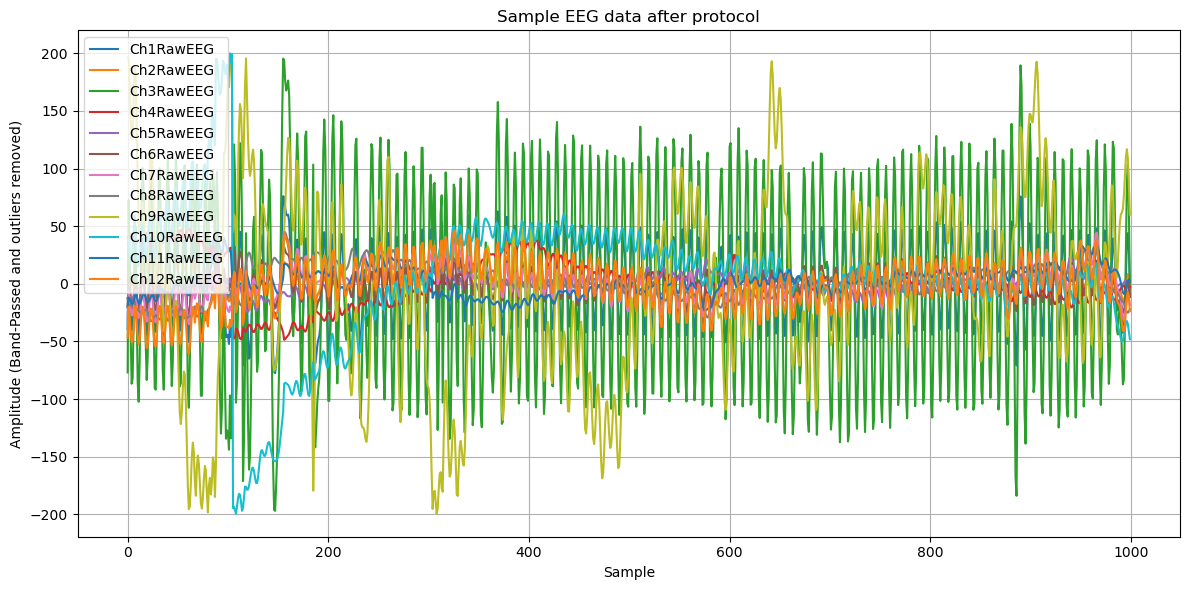

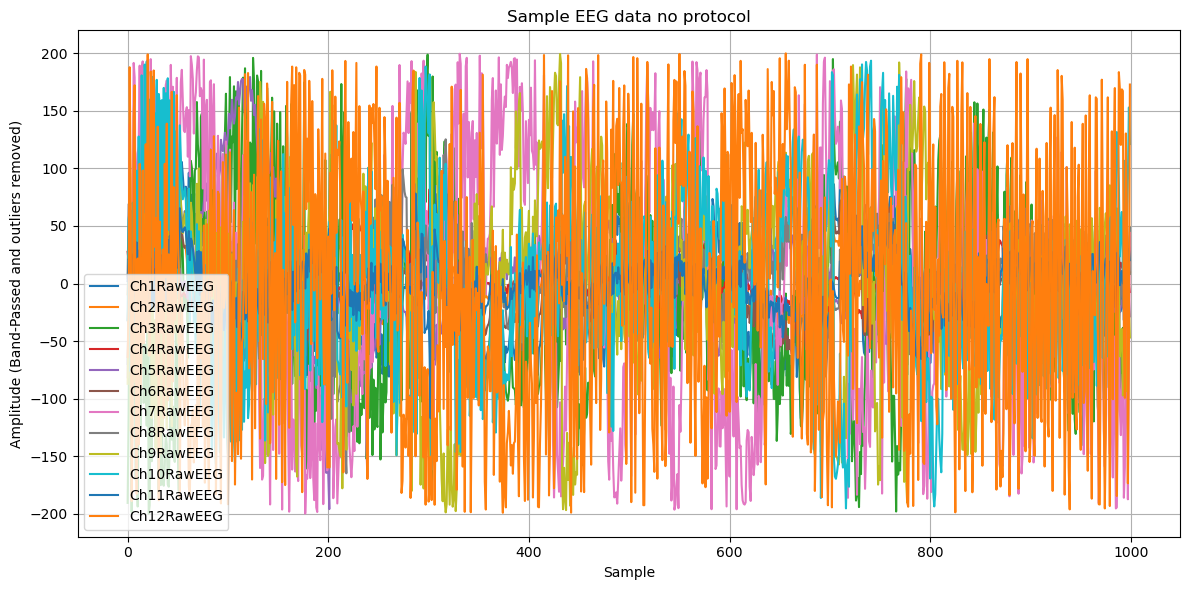

In [18]:
sample_datapoints=range(1000,2000)
for condition in no_outliers_data:
    plot_filtered_data(no_outliers_data[condition].iloc[sample_datapoints], f'{condition}')

Here we see there are some good channels behind bad channels. We need to remove bad channels first, otherwise complete rows of channels will be removed during the outlier extraction

## Removing bad channels

In [19]:
# Using Voltage peak to peak (Vpp) and sliding windows
# @TODO: Turn this into a function
window_size_seconds = 2
window_size_samples = sampling_rate*window_size_seconds
num_windows = int(len(filtered_df_dict[condition_to_check])/window_size_samples)
vpps = defaultdict(list)
for channel in eeg_columns:
    eeg_values_per_ch = filtered_df_dict[condition_to_check][channel].values
    for i in range(1,num_windows):
        window_data = eeg_values_per_ch[i*window_size_samples:(i+1)*window_size_samples]
        vpps[channel].append(np.max(window_data) - np.min(window_data))


Text(0.5, 1.0, 'Voltage peak to peak for each window and channel')

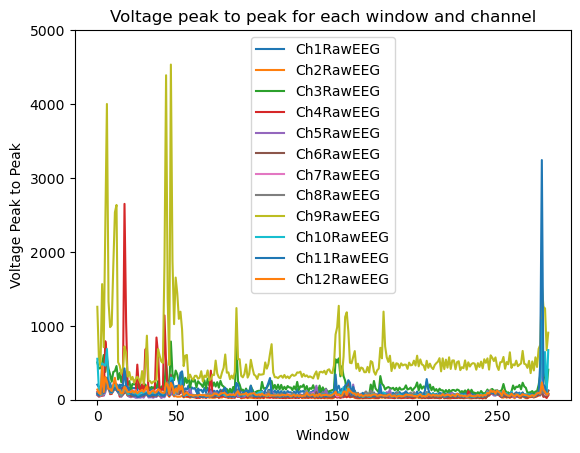

In [20]:
vpps_df = pd.DataFrame.from_dict(vpps)
vpps_df.plot()
plt.ylim((0,5000))
plt.xlabel('Window')
plt.ylabel('Voltage Peak to Peak')
plt.title('Voltage peak to peak for each window and channel')

In [23]:
# Let's search percentage of windows above threshold for each channel:
channel = eeg_columns[0]
threshold_vpp = 200
threshold_proportion_windows = 0.5
good_eeg_channels = []
bad_eeg_channels = []
for channel in eeg_columns:
    is_window_above_threshold = vpps_df[channel] > threshold_vpp
    percent_over_threshold = sum(is_window_above_threshold)/len(is_window_above_threshold)
    print(f'For channel {channel}, {np.round(percent_over_threshold, 2)} of windows are over threhold {threshold_vpp}')
    if percent_over_threshold > threshold_proportion_windows:
        bad_eeg_channels.append(channel)
    elif percent_over_threshold <= threshold_proportion_windows:
        good_eeg_channels.append(channel) 

For channel Ch1RawEEG, 0.04 of windows are over threhold 200
For channel Ch2RawEEG, 0.0 of windows are over threhold 200
For channel Ch3RawEEG, 0.3 of windows are over threhold 200
For channel Ch4RawEEG, 0.06 of windows are over threhold 200
For channel Ch5RawEEG, 0.02 of windows are over threhold 200
For channel Ch6RawEEG, 0.02 of windows are over threhold 200
For channel Ch7RawEEG, 0.02 of windows are over threhold 200
For channel Ch8RawEEG, 0.02 of windows are over threhold 200
For channel Ch9RawEEG, 1.0 of windows are over threhold 200
For channel Ch10RawEEG, 0.05 of windows are over threhold 200
For channel Ch11RawEEG, 0.08 of windows are over threhold 200
For channel Ch12RawEEG, 0.03 of windows are over threhold 200


In [24]:
bad_eeg_channels

['Ch9RawEEG']

## Removing bad epochs again
But only considering good channels this time

In [25]:
print(f'Percentage of datapoints kept after removing outliers above  threshold:')

print('threshold\t% before removing bad channels\t% after removing bad channels')
for threshold in thresholds_to_test:
    datapoints_without_outliers = len(remove_outliers(filtered_df_dict[condition_to_check][good_eeg_channels], threshold=threshold))
    datapoints_without_outliers_all_ch = len(remove_outliers(filtered_df_dict[condition_to_check], threshold=threshold))
    print(f'{threshold}\t{int(datapoints_without_outliers_all_ch/datapoints_orig*100)}%\t{int(datapoints_without_outliers/datapoints_orig*100)}%')



Percentage of datapoints kept after removing outliers above  threshold:
threshold	% before removing bad channels	% after removing bad channels
25	9%	0%
50	0%	76%
100	73%	93%
150	88%	96%
200	93%	98%
500	98%	99%
10000000	100%	100%


In [26]:
# Now I feel more comfortable of choosing a threshold of 100 even!
chosen_threshold = 100
no_outliers_data = dict()
for condition in df_dict:
    no_outliers_data[condition] = remove_outliers(filtered_df_dict[condition][good_eeg_channels], threshold=chosen_threshold)

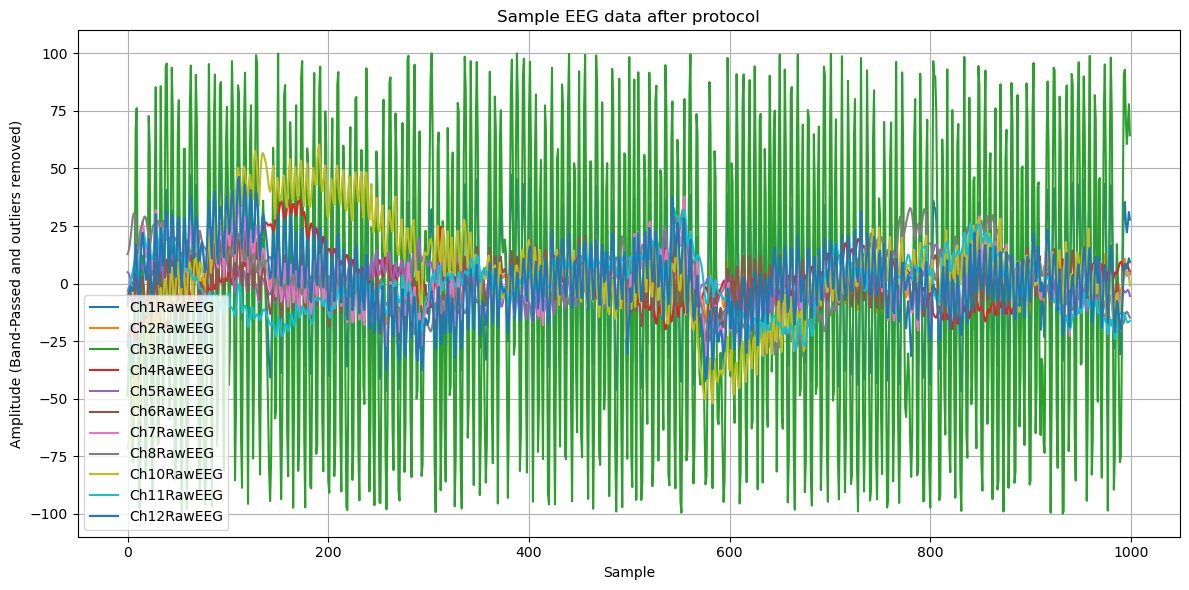

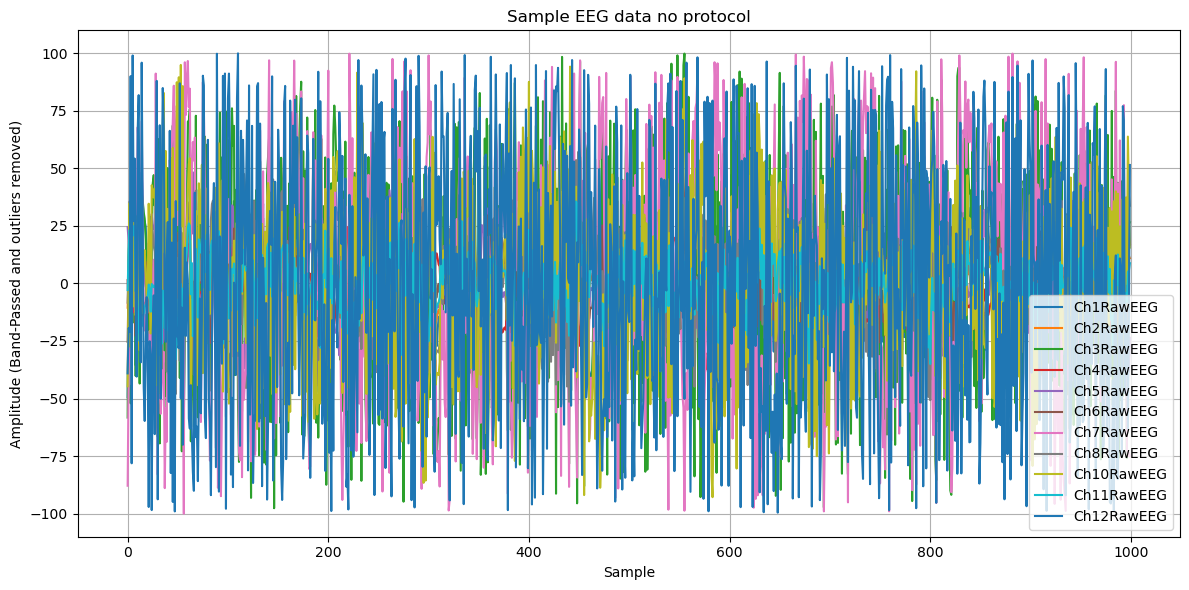

In [27]:
sample_datapoints=range(1000,2000)
for condition in no_outliers_data:
    plot_filtered_data(no_outliers_data[condition].iloc[sample_datapoints], f'{condition}')

There are still some extaneous oscillations. What is their frequency? 60 Hz

In [32]:
df_dict.keys()

dict_keys(['Sample EEG data after protocol', 'Sample EEG data no protocol'])

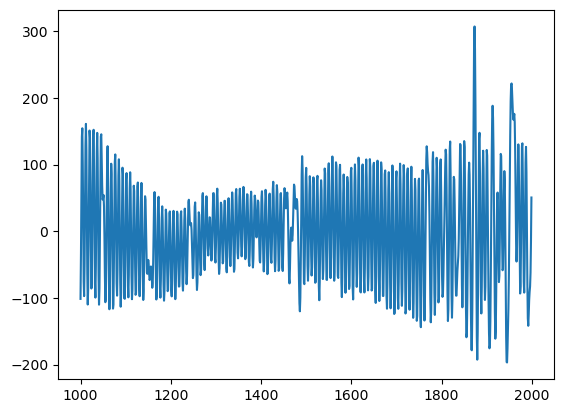

In [33]:
filtered_df_dict['Sample EEG data after protocol']['Ch3RawEEG'].iloc[sample_datapoints].plot()
y = filtered_df_dict['Sample EEG data after protocol']['Ch3RawEEG'].iloc[sample_datapoints].values

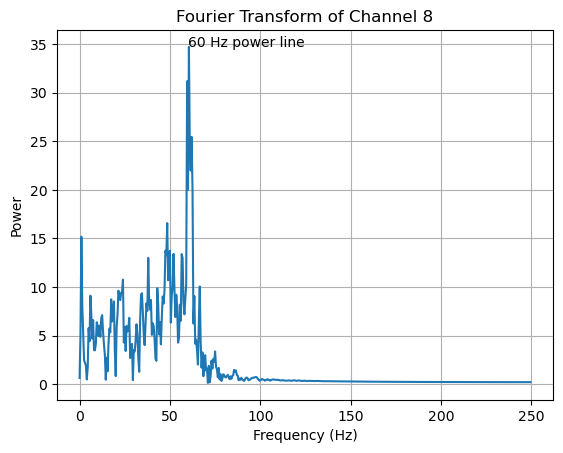

In [34]:
# Number of sample points
N = len(y)
# sample spacing
T = 1.0 / sampling_rate
x = np.linspace(0.0, N*T, N, endpoint=False)
yf = fft.fft(y)
xf = fft.fftfreq(N, T)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.title('Fourier Transform of Channel 8')
plt.ylabel("Power")
plt.xlabel("Frequency (Hz)")
plt.annotate("60 Hz power line", [60, max(2.0/N * np.abs(yf[0:N//2]))])
plt.show()

Okay, the extraneous oscillation is just the 60 Hz power line. Our filter is low order (5), so not strong enough to keep it out. 

It could also mean that this channel didn't have good enough contact, making me reconsider my Voltage peak-to-peak threshold to select good channels

## Now for all files: Let's find global bad channels

Load file, filter with the right parameters (filter order=5), calculate Vpp and detect bad channels

In [35]:
vpps_df

,Ch1RawEEG,Ch2RawEEG,Ch3RawEEG,Ch4RawEEG,Ch5RawEEG,Ch6RawEEG,Ch7RawEEG,Ch8RawEEG,Ch9RawEEG,Ch10RawEEG,Ch11RawEEG,Ch12RawEEG
0,203.020314,62.272060,504.338137,105.928134,62.662893,80.380258,100.383970,95.825635,1257.059798,553.625124,80.076435,137.804612
1,164.568698,41.754848,421.457653,69.915547,42.220288,53.454904,76.292733,64.613747,545.854142,133.883748,63.392785,91.550777
2,180.925746,47.570478,427.263975,58.613296,53.017803,56.739973,57.859717,82.364135,462.633433,65.149666,83.667828,76.669570
3,169.327102,69.281355,487.610067,52.698950,206.085067,123.604153,66.403839,63.547922,1564.170362,491.673554,154.218568,453.487996
4,249.012488,72.305627,605.007877,67.484405,53.404178,66.412528,73.724466,92.986196,710.943098,476.621108,89.258754,103.920106
...,...,...,...,...,...,...,...,...,...,...,...,...
278,169.411707,124.922544,1219.518579,113.951209,671.175296,183.496620,249.182116,155.702173,1552.963092,1072.614456,3242.219174,233.320357
279,91.180983,57.315745,378.253615,38.620721,72.425277,46.754211,133.131783,89.307364,1258.907458,318.733458,201.949405,131.115012
280,122.478131,44.615165,298.895932,47.001889,195.605091,71.618484,70.666655,97.225005,1234.153141,645.883000,175.129153,107.683650
281,64.790651,31.003490,164.549750,23.555515,62.790802,45.839370,63.898290,70.616187,669.502284,68.326279,73.653468,67.284380


In [36]:
# @TODO Replace loops with vectorized functions

simplified_name = "_".join(filenames[0].split(os.sep)[-1].split('_')[0:-2])
vpps_all_files = dict()
filtered_eeg_all_files = dict()
for file in filenames:
    raw_eeg_df = pd.read_csv(file)
    high_pass_filtered_array = butter_highpass_filter(raw_eeg_df[eeg_columns].values, highcut, sampling_rate, order=filter_order)
    band_pass_filtered_array = butter_lowpass_filter(high_pass_filtered_array, lowcut, sampling_rate, order=filter_order)
    filtered_eeg_df = pd.DataFrame(band_pass_filtered_array, columns=eeg_columns)
    filtered_eeg_all_files[file] = filtered_eeg_df
    num_windows = int(len(filtered_eeg_df)/window_size_samples)
    vpps = defaultdict(list)
    # Create Vpp array
    for channel in eeg_columns:
        eeg_values_per_ch = filtered_eeg_df[channel].values
        for i in range(1,num_windows):
            window_data = eeg_values_per_ch[i*window_size_samples:(i+1)*window_size_samples]
            vpps[channel].append(np.max(window_data) - np.min(window_data))
    vpps_all_files[file] = pd.DataFrame.from_dict(vpps)



In [37]:
# Find bad channels
bad_channels = defaultdict(list)
good_channels = defaultdict(list)
bad_channel_count = defaultdict(int)
for file in filenames:
    for channel in eeg_columns:
        is_window_above_threshold = vpps_all_files[file][channel] > threshold_vpp
        percent_over_threshold = sum(is_window_above_threshold)/len(is_window_above_threshold)
        if percent_over_threshold > threshold_proportion_windows:
            bad_channels[file].append(channel)
            bad_channel_count[channel] += 1
        elif percent_over_threshold <= threshold_proportion_windows:
            good_channels[file].append(channel) 
    # print(f'For file {file},\nbad channels are {bad_channels[file]}')






In [38]:
bad_channel_count

defaultdict(int,
            {'Ch3RawEEG': 5,
             'Ch7RawEEG': 6,
             'Ch12RawEEG': 4,
             'Ch9RawEEG': 9,
             'Ch1RawEEG': 2,
             'Ch2RawEEG': 1,
             'Ch6RawEEG': 1,
             'Ch8RawEEG': 1,
             'Ch10RawEEG': 1,
             'Ch11RawEEG': 1})

We can readily see which channels to exclude! 

In [39]:
num_bad_channels_per_file = {key: len(value) for key, value in bad_channels.items()}
num_bad_channels_per_file

{'data/relax_protocol\\Post-No-Protocol-Reading_2_a59d54dbeb0561f6.csv': 3,
 'data/relax_protocol\\Post-No-Protocol-Reading_3_6ec4773de7bdd332.csv': 2,
 'data/relax_protocol\\Post-No-Protocol-Reading_4_5e3f45ddcf9f24fb.csv': 2,
 'data/relax_protocol\\Post-No-Protocol-Reading_5_8f35d37b247631df.csv': 9,
 'data/relax_protocol\\Post-No-Protocol-Watching_Lecture_1_84cba488007bbde6.csv': 2,
 'data/relax_protocol\\Post-Relax-Protocol-Reading_1-2_fe965c878635715b.csv': 1,
 'data/relax_protocol\\Post-Relax-Protocol-Reading_1_e64ef2cf3314a11d.csv': 3,
 'data/relax_protocol\\Post-Relax-Protocol-Reading_2_08edc179d3350ea7.csv': 1,
 'data/relax_protocol\\Post-Relax-Protocol-Reading_3_2332e9873e86357c.csv': 3,
 'data/relax_protocol\\Post-Relax-Protocol-Working_4_8f0fac001e382227.csv': 1,
 'data/relax_protocol\\Post-Relax-Protocol-Working_5_9c117b95ab00f86c.csv': 4}

In [40]:
# Including files that have less than 4 bad channels
bad_channel_threshold = 4
files_to_include = []
for file in num_bad_channels_per_file:
    if num_bad_channels_per_file[file] < bad_channel_threshold:
        files_to_include.append(file)

In [41]:
files_to_include

['data/relax_protocol\\Post-No-Protocol-Reading_2_a59d54dbeb0561f6.csv',
 'data/relax_protocol\\Post-No-Protocol-Reading_3_6ec4773de7bdd332.csv',
 'data/relax_protocol\\Post-No-Protocol-Reading_4_5e3f45ddcf9f24fb.csv',
 'data/relax_protocol\\Post-No-Protocol-Watching_Lecture_1_84cba488007bbde6.csv',
 'data/relax_protocol\\Post-Relax-Protocol-Reading_1-2_fe965c878635715b.csv',
 'data/relax_protocol\\Post-Relax-Protocol-Reading_1_e64ef2cf3314a11d.csv',
 'data/relax_protocol\\Post-Relax-Protocol-Reading_2_08edc179d3350ea7.csv',
 'data/relax_protocol\\Post-Relax-Protocol-Reading_3_2332e9873e86357c.csv',
 'data/relax_protocol\\Post-Relax-Protocol-Working_4_8f0fac001e382227.csv']

In [42]:
# Repeating the check of which channels to exclude, only with "good" files
# Find bad channels
bad_channels = defaultdict(list)
good_channels = defaultdict(list)
bad_channel_count = defaultdict(int)
for file in files_to_include:
    for channel in eeg_columns:
        is_window_above_threshold = vpps_all_files[file][channel] > threshold_vpp
        percent_over_threshold = sum(is_window_above_threshold)/len(is_window_above_threshold)
        if percent_over_threshold > threshold_proportion_windows:
            bad_channels[file].append(channel)
            bad_channel_count[channel] += 1
        elif percent_over_threshold <= threshold_proportion_windows:
            good_channels[file].append(channel) 
    # print(f'For file {file},\nbad channels are {bad_channels[file]}')



In [43]:
bad_channel_count

defaultdict(int,
            {'Ch3RawEEG': 3,
             'Ch7RawEEG': 4,
             'Ch12RawEEG': 2,
             'Ch9RawEEG': 7,
             'Ch1RawEEG': 1,
             'Ch11RawEEG': 1})

In [44]:
# Selecting channels that are bad in less than 5 files
bad_ch_num_files_threshold = 5
channels_to_include = []
for channel in eeg_columns:
    if not channel in bad_channel_count.keys():
        # If it is not in the bad_channel_count it means this channel wasn't bad in any file
        channels_to_include.append(channel)
        continue
    if bad_channel_count[channel] < bad_ch_num_files_threshold:
        channels_to_include.append(channel)
channels_to_include



['Ch1RawEEG',
 'Ch2RawEEG',
 'Ch3RawEEG',
 'Ch4RawEEG',
 'Ch5RawEEG',
 'Ch6RawEEG',
 'Ch7RawEEG',
 'Ch8RawEEG',
 'Ch10RawEEG',
 'Ch11RawEEG',
 'Ch12RawEEG']

## Removing epochs on the filtered signals

For the channels and files of interest

In [47]:
filtered_eeg_all_files.keys()

dict_keys(['data/relax_protocol\\Post-No-Protocol-Reading_2_a59d54dbeb0561f6.csv', 'data/relax_protocol\\Post-No-Protocol-Reading_3_6ec4773de7bdd332.csv', 'data/relax_protocol\\Post-No-Protocol-Reading_4_5e3f45ddcf9f24fb.csv', 'data/relax_protocol\\Post-No-Protocol-Reading_5_8f35d37b247631df.csv', 'data/relax_protocol\\Post-No-Protocol-Watching_Lecture_1_84cba488007bbde6.csv', 'data/relax_protocol\\Post-Relax-Protocol-Reading_1-2_fe965c878635715b.csv', 'data/relax_protocol\\Post-Relax-Protocol-Reading_1_e64ef2cf3314a11d.csv', 'data/relax_protocol\\Post-Relax-Protocol-Reading_2_08edc179d3350ea7.csv', 'data/relax_protocol\\Post-Relax-Protocol-Reading_3_2332e9873e86357c.csv', 'data/relax_protocol\\Post-Relax-Protocol-Working_4_8f0fac001e382227.csv', 'data/relax_protocol\\Post-Relax-Protocol-Working_5_9c117b95ab00f86c.csv'])

In [45]:
threshold_vpp_final = 100
print(f'Percentage of datapoints kept after removing outliers above  threshold {threshold_vpp_final}:')
cleaned_data_dict = dict()
for file in files_to_include:
    datapoints_orig = len(filtered_eeg_all_files[file])
    cleaned_data_dict[file] = remove_outliers(filtered_eeg_all_files[file][channels_to_include], threshold=threshold_vpp_final)
    datapoints_without_outliers = len(cleaned_data_dict[file])
    print(f'{int(datapoints_without_outliers/datapoints_orig*100)}%')


Percentage of datapoints kept after removing outliers above  threshold 100:
23%
33%
50%
87%
93%
54%
0%
74%
87%


In [56]:
# Turning the dictionary in two dataframes, one for each condition
files_to_include
relax_protocol = "Relax-Protocol"
no_protocol = "No-Protocol"
relax_protocol_filenames = []
no_protocol_filenames = []
for filename in files_to_include:
    if relax_protocol in filename:
        relax_protocol_filenames.append(filename)
    elif no_protocol in filename:
        no_protocol_filenames.append(filename)


In [58]:
relax_protocol_dict = {k: cleaned_data_dict[k] for k in relax_protocol_filenames}
no_protocol_dict = {k: cleaned_data_dict[k] for k in no_protocol_filenames}

In [59]:
relax_protocol_df = pd.concat(relax_protocol_dict.values(), ignore_index=True)
no_protocol_df = pd.concat(no_protocol_dict.values(), ignore_index=True)

In [60]:
print(f'Number of minutes on the relax protocol dataset: {round(len(relax_protocol_df)/sampling_rate/60)}')
print(f'Number of minutes on the no protocol dataset: {round(len(no_protocol_df)/sampling_rate/60)}')

Number of minutes on the relax protocol dataset: 32
Number of minutes on the no protocol dataset: 29


In [63]:
data_folder = 'data/relax_protocol/cleaned/'
if not os.path.exists(data_folder):
    os.makedirs(data_folder)
relax_protocol_df.to_csv(data_folder + 'eeg_relax_protocol_cleaned.csv')
no_protocol_df.to_csv(data_folder + 'eeg_no_protocol_cleaned.csv')